# Health Insurance Cross Sell Prediction

### Predict Health Insurance Owners' who will be interested in Vehicle Insurance

## Context
An insurance company, currently offering Health Insurance with coverage up to $200,000, plans to expand its product range to include a new segment: Vehicle Insurance.

Since it is cheaper to sell to existing customers than to acquire new ones, the business team wants to identify which customers in the current base might be interested in buying the new Vehicle Insurance. To do this, the company needs a predictive model that can rank customers by their purchase propensity, allowing for more effective targeting of offers.

Insurance is an agreement where a company promises to provide compensation for specific losses (such as damage, illness, or death) in exchange for payment of a premium. For example, a customer might pay an annual premium to ensure that if they are hospitalized, the insurance company will cover the costs up to a certain limit.

Developing this predictive model can save the company time and resources. With a ranked list of customers based on their purchase propensity, the business team can better target offers and increase the chances of making sales.

[The data is available on Kaggle](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction)

## Aim
Create a purchase propensity score for this customer base and rank customers based on this score. Considering the costs involved in sending offers to customers, the challenge is to effectively order the customers.

Questions to answer:

- Who are the customers with the highest purchase propensity?
- Which customers should we target with offers to maximize the company's revenue?

## Data Dictionary
- Train Data

| **Variable**             | **Definition**                                                                                      |
|--------------------------|-----------------------------------------------------------------------------------------------------|
| `id`                     | Unique ID for the customer                                                                          |
| `Gender`                 | Gender of the customer                                                                              |
| `Age`                    | Age of the customer                                                                                 |
| `Driving_License`        | Indicates whether the customer has a Driving License: 0 = No, 1 = Yes                               |
| `Region_Code`            | Unique code for the region of the customer                                                          |
| `Previously_Insured`     | Indicates if the customer already has Vehicle Insurance: 0 = No, 1 = Yes                            |
| `Vehicle_Age`            | Age of the Vehicle                                                                                  |
| `Vehicle_Damage`         | Indicates if the customer’s vehicle has been damaged in the past: 0 = No, 1 = Yes                   |
| `Annual_Premium`         | The amount the customer needs to pay as a premium for the year                                      |
| `Policy_Sales_Channel`   | Anonymized code for the channel used to reach the customer (e.g., Different Agents, Over Email, Over Phone, In Person, etc.) |
| `Vintage`                | Number of days the customer has been associated with the company                                    |
| `Response`               | Indicates if the customer is interested in the offer: 0 = No, 1 = Yes                               |

- Test Data

The test data contains the same variables as the train data, but it doesn't include the target variable `Response`.


# 0.0. IMPORTS

In [50]:
import pandas                       as pd
import numpy                        as np 
import matplotlib.pyplot            as plt
import seaborn                      as sns
import scipy.stats                  as stats
from sklearn import model_selection as ms
from sklearn import ensemble        as en

from scipy.stats import chi2_contingency


plt.style.use('seaborn-v0_8-whitegrid')



## 0.1. Loading Dataset

In [51]:
df_raw = pd.read_csv( '../data/raw/train.csv')

## 0.2 Helper Functions

In [52]:
"""
    This function summarizes the age feature into groups.
"""
def categorize_age(age):
    if age <= 30:
        return 'young_adults(18-30)'
    elif age <= 45:
        return 'adults(31-45)'
    elif age <= 60:
        return 'middle_age(46-60)'
    else:
        return 'seniors(61+)'
# ------------------------------------------------------------------

# 1.0. DATA DESCRIPTION

In [53]:
df1 = df_raw.copy()

## 1.1 Rename Columns To Lowercase

In [54]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

lowercase = lambda x: x.lower()

cols_new = list(map(lowercase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2 Data Dimension

In [55]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [56]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [57]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Check Duplicate ID

In [58]:
df1['id'].nunique()

381109

- Because the number of IDs matches the number of rows in the dataset, the IDs are unique 

## 1.6 Checking Values In Features

In [59]:
df1.nunique().sort_values()

gender                       2
driving_license              2
vehicle_damage               2
previously_insured           2
response                     2
vehicle_age                  3
region_code                 53
age                         66
policy_sales_channel       155
vintage                    290
annual_premium           48838
id                      381109
dtype: int64

- 50% of the features have 2 or 3 unique values

## 1.7 Checking Percentage Zeros 

In [60]:
features = df1.columns

percentage_zeros = df1[features].apply(lambda x: (x == 0).mean() * 100)
percentage_zeros_df = percentage_zeros.reset_index()
percentage_zeros_df.columns = ['features', 'porcentagem_zeros']
percentage_zeros_df.sort_values('porcentagem_zeros', ascending=False)

,features,porcentagem_zeros
11,response,87.743664
5,previously_insured,54.178988
4,region_code,0.530294
3,driving_license,0.213062
2,age,0.000000
1,gender,0.000000
0,id,0.000000
6,vehicle_age,0.000000
7,vehicle_damage,0.000000
8,annual_premium,0.000000


- I tried to identify if there were any features with many zero values, as this would indicate low variability, which is generally bad for modeling.
- The features 'gender', 'vehicle_damage', and 'vehicle_age' do not have zeros because their values are in text rather than numbers.

In [61]:
df1.vehicle_age.value_counts()

vehicle_age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

- It will be necessary to encode some variables such as 'vehicle_damage', 'vehicle_age', and 'gender'.

## 1.8 Descriptive Statistical

In [62]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [63]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max )  ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [64]:
df2 = df1.copy()

## 2.1 Creating a List of Hypotheses 

**1.** There is no difference in interest in vehicle insurance between different age groups.

**2.** Customers who already have vehicle insurance (previously_insured = 1) are less interested in purchasing the new vehicle insurance.

**3.** There is no relationship between previous vehicle damage and interest in vehicle insurance.

**4.** There is no difference in the effectiveness of different sales channels in generating interest in the new vehicle insurance offer.

**5.** There is no significant relationship between the annual premium and the customer's interest in vehicle insurance.


## 2.2 Feature Engineering

In [65]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [66]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 0 if x == '< 1 Year' else 1 if x== '1-2 Year' else 2  )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x =='Yes' else 0 )

# gender
df2['gender'] = df2['gender'].apply( lambda x: 1 if x =='Male' else 0 )

# age_group
df2['age_group'] = df2['age'].apply(categorize_age)

- #### vehicle_age: mapped to 0 for < 1 Year, 1 for 1-2 Year, and 2 for > 2 Years.
- #### vehicle_damage: mapped to 1 for 'Yes' and 0 for 'No'.
- #### gender: mapped to 1 for 'Male' and 0 for 'Female'.
- #### age_group: applied function to group ages into categories. 'young_adults(18-30)' <=30, 'adults(31-45)' <=45, 'middle_age(46-60)' <=60, 'seniors(61+)'

In [67]:
df2.head() 

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,age_group
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,adults(31-45)
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0,seniors(61+)
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1,middle_age(46-60)
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0,young_adults(18-30)
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0,young_adults(18-30)


# 3.0. Data Filtering

In [68]:
df3 = df2.copy()

# 4.0. EDA

In [69]:
df4 = df3.copy()

## 4.1 Univariate Analysis

Since this is a classification problem, my goal is to identify variables that differ from each other so that my classifier can effectively set the thresholds in the space where it will separate the classes.

### 4.1.1 Response Variable

In [70]:
response_freq = df4['response'].value_counts()
response_freq_rel = df4['response'].value_counts(normalize=True)

print("Absolute Frequency:\n", response_freq)
print("Relative Frequency:\n", response_freq_rel)


Absolute Frequency:
 response
0    334399
1     46710
Name: count, dtype: int64
Relative Frequency:
 response
0    0.877437
1    0.122563
Name: proportion, dtype: float64


### 4.1.2 Gender

In [71]:
# 'gender'
df4.gender.value_counts(1)

gender
1    0.540761
0    0.459239
Name: proportion, dtype: float64

### 4.1.3 Region Code

<Axes: xlabel='region_code', ylabel='id'>

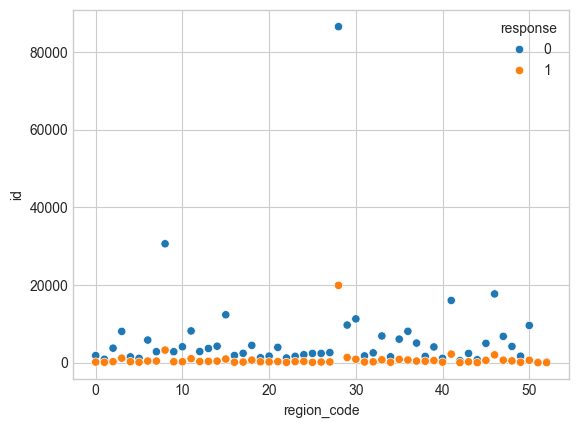

In [72]:
# region code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response']).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux)

### 4.1.4 Previously Insured

In [73]:
# tabela de contingência
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)


response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.5 Vehicle age

0 = < 1 Year

1 = 1-2 Years

2 = > 2 Years

In [74]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,1,0,0.434285
1,0,0,0.413488
2,1,1,0.091328
3,2,0,0.029663
4,0,1,0.018897
5,2,1,0.012338


- Over 2 years is not a discriminative category

### 4.1.6 Policy sales channel

<Axes: xlabel='response', ylabel='policy_sales_channel'>

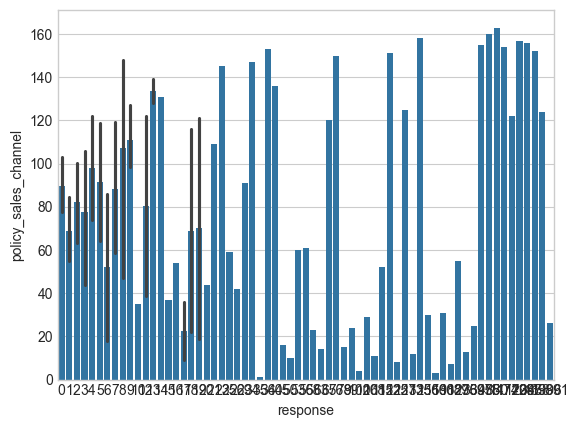

In [75]:
plt.figsize=(20,8)
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux)

### 4.1.7 Vintage

<Axes: xlabel='vintage', ylabel='Count'>

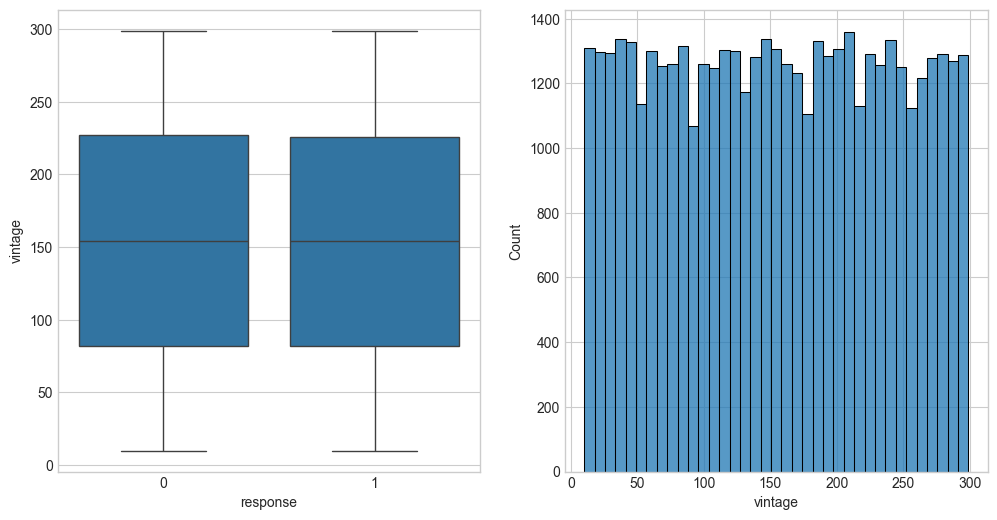

In [76]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(1, 2, 2)
aux = df4[df4['response'] == 1]['vintage']
sns.histplot(aux)


- Both classes have the same graphs and distributions for this variable, meaning that this feature has no relevance for class discrimination.

### 4.1.8 Annual Premium

In [77]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

<Axes: xlabel='annual_premium', ylabel='Count'>

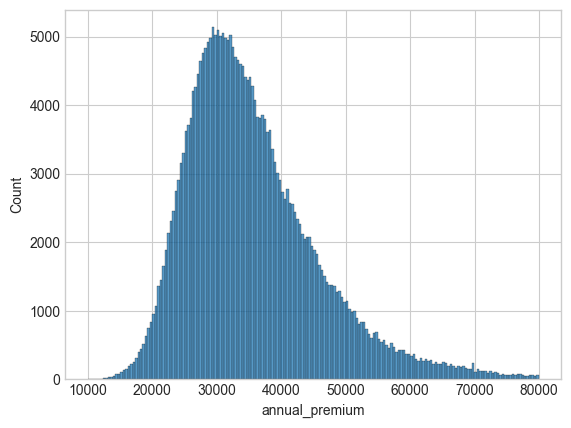

In [ ]:
# annual_premium
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000) ]

aux_1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux_1)

<Axes: xlabel='annual_premium', ylabel='Count'>

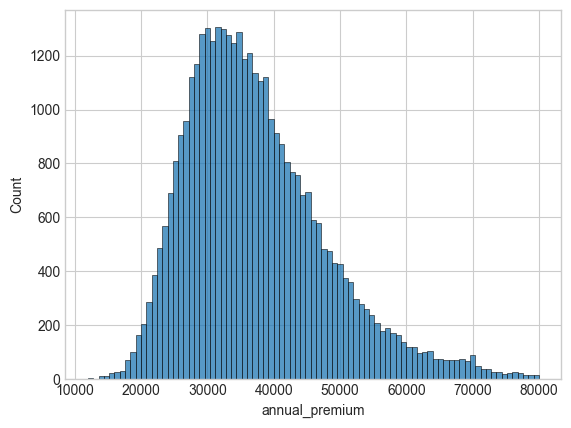

In [ ]:
aux_2 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux_2)

- Just like in the boxplot, the distributions of 'annual_premium' for the negative and positive classes are quite similar, meaning that this feature has low discriminative power between the classes.

### 4.1.9 Driving License

In [ ]:
df4['driving_license'].value_counts(1)


driving_license
1    0.997869
0    0.002131
Name: proportion, dtype: float64

In [ ]:
df4.groupby('response')['driving_license'].value_counts(1)

response  driving_license
0         1                  0.997694
          0                  0.002306
1         1                  0.999122
          0                  0.000878
Name: proportion, dtype: float64

### 4.1.10 Vehicle Damage

In [ ]:
df4.vehicle_damage.value_counts(1)

vehicle_damage
1    0.504877
0    0.495123
Name: proportion, dtype: float64

In [ ]:
df4.groupby('response')['vehicle_damage'].value_counts(1)

response  vehicle_damage
0         0                 0.561347
          1                 0.438653
1         1                 0.978977
          0                 0.021023
Name: proportion, dtype: float64

## 4.2. Bivariate Analysis

**1.** There is no difference in interest in vehicle insurance between different age groups.

**2.** Customers who already have vehicle insurance (previously_insured = 1) are less interested in purchasing the new vehicle insurance.

**3.** There is no relationship between previous vehicle damage and interest in vehicle insurance.

**4.** There is no difference in the effectiveness of different sales channels in generating interest in the new vehicle insurance offer.

**5.** There is no significant relationship between the annual premium and the customer's interest in vehicle insurance.


### **H1.** There is no difference in interest in vehicle insurance between different age groups.

- **Rejected the Null Hypothesis**
- The very low p-value and the high chi-square statistic support the hypothesis that customers in specific age groups have different levels of interest in vehicle insurance. In other words, age is a relevant discriminatory feature.
- The adults group (31-45) is the most interested in vehicle insurance.

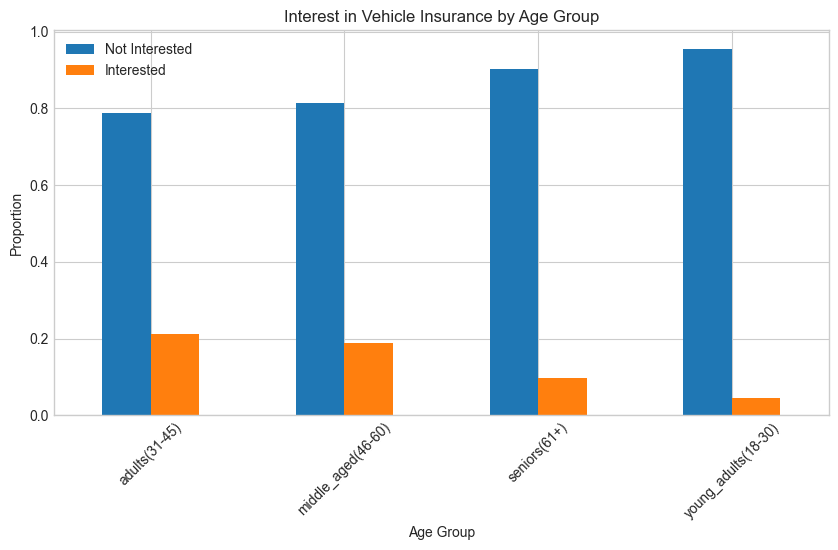

In [ ]:
ct = pd.crosstab(df4['age_group'], df4['response'], normalize='index')

# Stacked bar chart
ax = ct.plot(kind='bar', stacked=False, figsize=(10,5))
plt.title('Interest in Vehicle Insurance by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.legend(labels=['Not Interested', 'Interested'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
contingency_table = pd.crosstab(df4['age_group'], df4['response'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

significance_level = 0.05
if p_value < significance_level:
    print("We reject the null hypothesis.")
else:
    print("We do not reject the null hypothesis.")


Chi-square statistic: 19567.751131712215
P-value: 0.0
We reject the null hypothesis.


### **H2.** Customers who already have vehicle insurance (previously_insured = 1) are less interested in purchasing the new vehicle insurance.

In [ ]:
ct = pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)
ct

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


This variable might be a data leakage because it is highly related to the target variable. In 99% of the dataset, customers who already have automotive insurance are not interested in acquiring another one. Therefore, this feature is not very discriminative and could negatively impact the model's performance by leading to overfitting. In this context, the model might depend too much on this feature, reducing its ability to generalize to new data.


### **H3.** There is no relationship between previous vehicle damage and interest in vehicle insurance.


- **Rejected The Null Hypothesis**
- The extremely low p-value (0.0) indicates that the probability of observing this relationship by chance is practically zero. Statistically, this means that the relationship between previous vehicle damage and interest in insurance is highly significant. These results reject the null hypothesis, which stated that there is no relationship between previous vehicle damage and interest in vehicle insurance. Instead, they support the alternative hypothesis that customers whose vehicles have been damaged in the past are more interested in purchasing vehicle insurance.

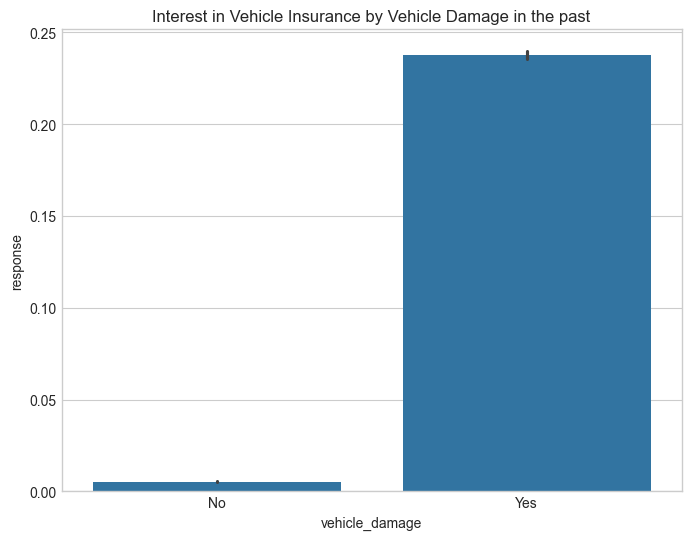

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='vehicle_damage', y='response', data=df4)
plt.title('Interest in Vehicle Insurance by Vehicle Damage in the past')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
contingency_table = pd.crosstab(df4['vehicle_damage'], df4['response'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

significance_level = 0.05
if p_value < significance_level:
    print("We reject the null hypothesis.")
else:
    print("We do not reject the null hypothesis.")


Chi-square statistic: 47864.76180117493
P-value: 0.0
We reject the null hypothesis.


### **H4.** There is no difference in the effectiveness of different sales channels in generating interest in the new vehicle insurance offer.


**Rejected The Null Hypothesis**
- The tests indicate that the probability of observing this relationship by chance is practically zero. Statistically, this means that the relationship between sales channels and interest in vehicle insurance is highly significant.

- They accept the alternative hypothesis that there is a significant difference in the effectiveness of the sales channels.

- In practical terms, this means that some sales channels are significantly more effective than others in generating interest in the new vehicle insurance product. The variation in effectiveness between channels cannot be attributed to chance.

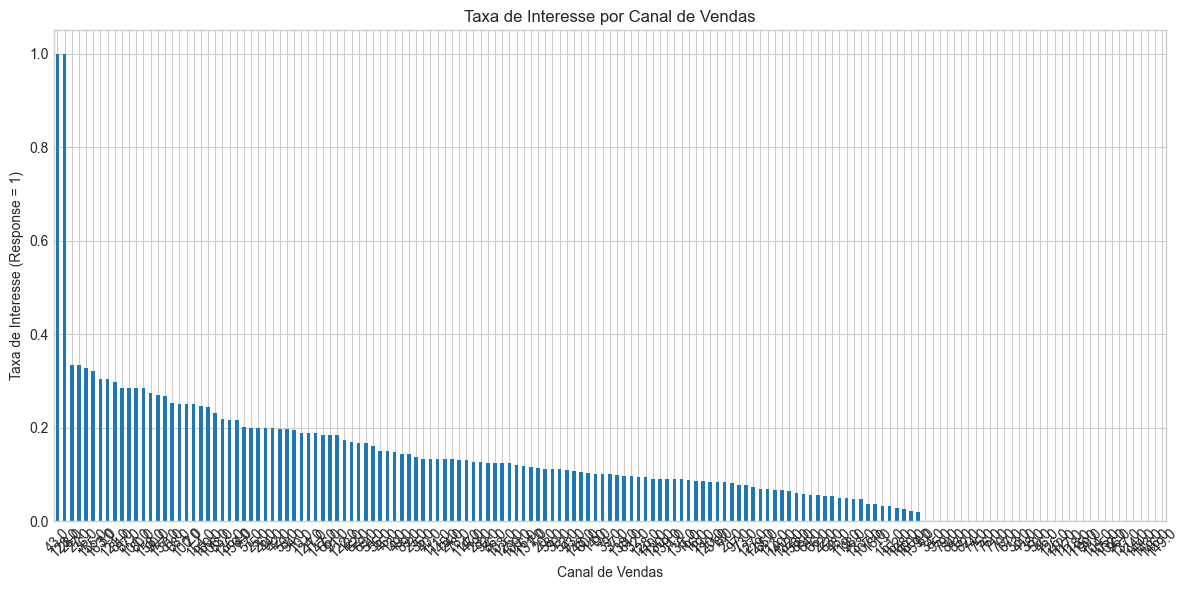

In [ ]:
channel_interest = df4.groupby('policy_sales_channel')['response'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))

channel_interest.plot(kind='bar')
plt.title('Taxa de Interesse por Canal de Vendas')
plt.xlabel('Canal de Vendas')
plt.ylabel('Taxa de Interesse (Response = 1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for the chi-square test
contingency_table = pd.crosstab(df4['policy_sales_channel'], df4['response'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print('Chi-square statistic: {}'.format(chi2))
print('P-value: {}'.format(p_value))

significance_level = 0.05
if p_value < significance_level:
    print("We reject the null hypothesis.")
else:
    print("We do not reject the null hypothesis.")

print("\nTop 5 most effective channels in generating interest:")
print(channel_interest.head())


Chi-square statistic: 26447.0328567449
P-value: 0.0
We reject the null hypothesis.

Top 5 most effective channels in generating interest:
policy_sales_channel
43.0     1.000000
123.0    1.000000
28.0     0.333333
27.0     0.333333
36.0     0.326923
Name: response, dtype: float64


### **H5.** There is no significant relationship between the annual premium and the customer's interest in vehicle insurance.

- Student's T-Test

The t-test is used to compare means between two groups.

Continuous Variable vs. Binary: 'annual_premium' (continuous) vs. 'response' (binary).

Assumptions: Assumes normality and homogeneity of variances.

- **Rejected The Null Hypothesis**
- The T-student test results show that the probability of observing this relationship between annual_premium and customer interest in vehicle insurance by chance is extremely low (p-value ≈ 3.72e-44).Statistically, this indicates a highly significant relationship between the annual premium and interest in vehicle insurance.

- We accept the alternative hypothesis that **there is a significant relationship between the annual premium and the customer's interest in vehicle insurance.**

- In practical terms, this means the amount of annual premium that a customer pays is strongly related to their interest in the vehicle insurance offer. This relationship is too strong to be attributed to random chance.


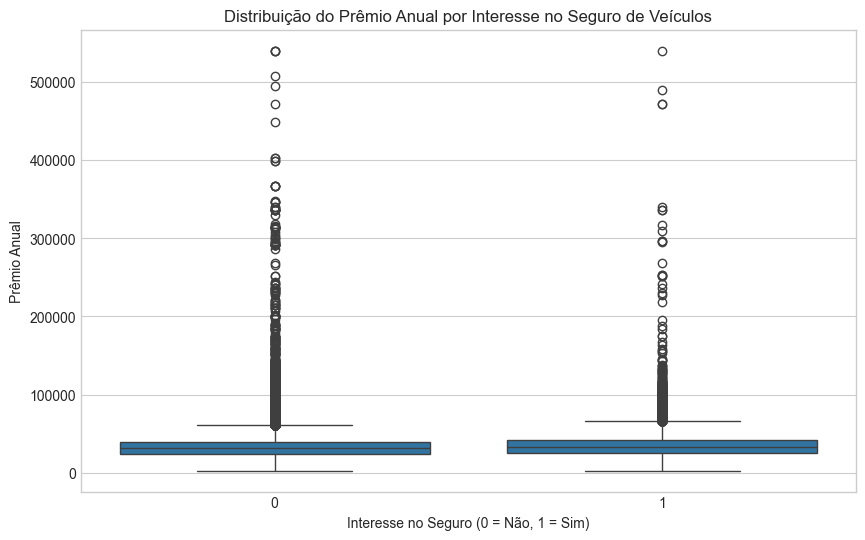

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='response', y='annual_premium', data=df4)
plt.title('Distribuição do Prêmio Anual por Interesse no Seguro de Veículos')
plt.xlabel('Interesse no Seguro (0 = Não, 1 = Sim)')
plt.ylabel('Prêmio Anual')
plt.show()

In [ ]:
#split groups
interested = df4[df4['response'] == 1]['annual_premium']
not_interested = df4[df4['response'] == 0]['annual_premium']

# t-student test
t_statistic, p_value = stats.ttest_ind(interested, not_interested)
print('T-statistic: {}'.format (t_statistic) )
print('P-value: {}'.format (p_value) )

significance_level = 0.05
if p_value < significance_level:
    print("We reject the null hypothesis.")
else:
    print("We do not reject the null hypothesis.")


T-statistic: 13.939784337147294
P-value: 3.7223151414267487e-44
We reject the null hypothesis.


# 5.0. Data Preparation

In [128]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

df5 = df4.copy()

In [ ]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.2 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [ ]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 5.1 Standardization

In [ ]:
scaler = StandardScaler()

df5['annual_premium'] = scaler.fit_transform( df5[['annual_premium']].values )

## 5.2 Rescaling

In [ ]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3 Encoder

In [ ]:
# gender - OHE / Target Encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Frequency Encoding / Target Encoding 
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - OHE / Order Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )




## 5.4 Treating outliers

In [ ]:
# Função para remover outliers usando o método IQR
#def remove_outliers(df, column):
 #   Q1 = df[column].quantile(0.25)
 #   Q3 = df[column].quantile(0.75)
 #   IQR = Q3 - Q1
 #   lower_bound = Q1 - 1.5 * IQR
 #   upper_bound = Q3 + 1.5 * IQR
 #   return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remover outliers
# df_clean = remove_outliers(df4, 'annual_premium')

In [ ]:
df5.head()

- Region code tem muitas categorias então vou usar Frequency ou Target encoding

## 5.5 Validation Preparation

In [ ]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = scaler.transform( x_validation[['annual_premium']].values)

# policy_salves_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

C:\Users\Samir\AppData\Local\Temp\ipykernel_1248\1242625080.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04615385 0.41538462 0.10769231 ... 0.09230769 0.04615385 0.38461538]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)
C:\Users\Samir\AppData\Local\Temp\ipykernel_1248\1242625080.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.816609   0.89619377 0.50519031 ... 0.71626298 0.3183391  0.23529412]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )
C:\Users\Samir\AppData\Local\Temp\ipykernel_1248\1242625080.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

## 5.6 Polynomial Transformation

# 6.0. Feature Selection

## 6.1 Feature Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                          feature  importance
0                         vintage    0.273247
1                  annual_premium    0.245265
2                             age    0.164985
3                     region_code    0.104679
4                  vehicle_damage    0.069201
5            policy_sales_channel    0.059548
6              previously_insured    0.054987
7        vehicle_age_under_1_year    0.012544
8   vehicle_age_between_1_2_years    0.007592
9                          gender    0.004740
10       vehicle_age_over_2_years    0.002753
11                driving_license    0.000460


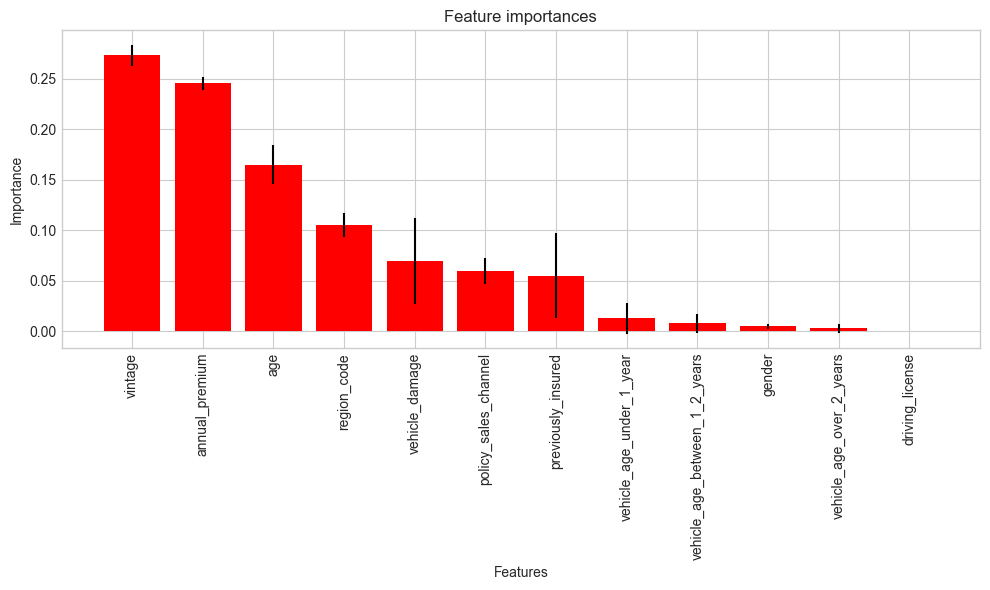

In [ ]:
# Calcula a importância das features
importances = forest.feature_importances_

# Calcula o desvio padrão das importâncias entre as árvores
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Ordena os índices das features por importância (decrescente)
indices = np.argsort(importances)[::-1]

# Cria um DataFrame para armazenar as features e suas importâncias
df = pd.DataFrame({'feature': x_train_n.columns, 'importance': importances})

# Ordena o DataFrame por importância (decrescente) e exibe
print('Feature ranking:')
print(df.sort_values('importance', ascending=False).reset_index(drop=True))

# Cria um gráfico de barras para visualizar as importâncias
plt.figure(figsize=(10, 6))
plt.title('Feature importances')

# Plota as barras de importância
plt.bar(range(x_train_n.shape[1]), importances[indices], 
        color='r', yerr=std[indices], align='center')

# Configura os rótulos do eixo x (nomes das features)
plt.xticks(range(x_train_n.shape[1]), x_train_n.columns[indices], rotation=90)

# Ajusta os limites do eixo x
plt.xlim([-1, x_train_n.shape[1]])

# Adiciona rótulos aos eixos
plt.xlabel('Features')
plt.ylabel('Importance')

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

# 7.0. Machine Learning Modelling

In [ ]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
'previously_insured', 'policy_sales_channel', 'vehicle_age_under_1_year']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 KNN

In [ ]:
from sklearn import neighbors as nh
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=3 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - mede o poder de generalização
yhat_knn = knn_model.predict_proba( x_val )

KeyboardInterrupt: 

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

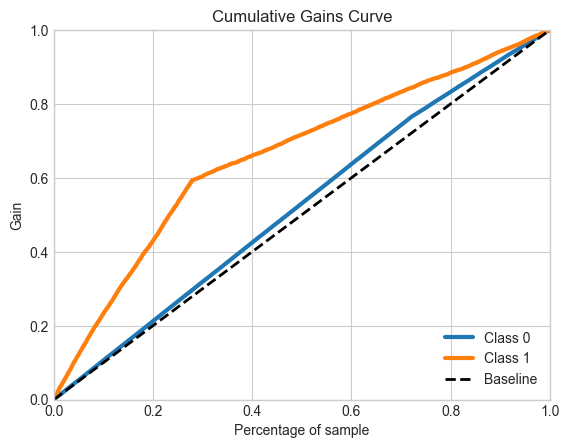

In [ ]:
import scipy
scipy.interp = np.interp

import scikitplot as skplt

# Curva de ganho acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

O gráfico da curva de ganho mostra que se a empresa abordar **30%** da amostra da base de dados ordenada pela maior propensão de compra, conseguirá alcançar **60%** dos clientes que estão interessados em comprar o novo seguro.

Quanto maior for a porcentagem de amostras que o meu modelo precisa para alcançar 100% dos interessados, maior será o custo para a empresa. Porque isso significa que a empresa gastará muitos recursos de marketing para entrar em contato com todas elas.

O ideal é que nosso modelo consiga alcançar 100% de pessoas interessadas (Gain) no menor número possível de porcentagem de pessoas. Lembrando que o nosso modelo ordena as amostras pela maior propensão de compra.

O modelo de regresão logística tem uma peformance melhor na ordenação da nossa base de dados. Justamente porque ele consegue alcançar 100% dos clientes interessados com aproximadamente 50% da base de dados ordenada pela propensão de compra.

## Métrica de curva de ganho
- Como resumir em 1 número?

## 7.2 Extra Trees

In [ ]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

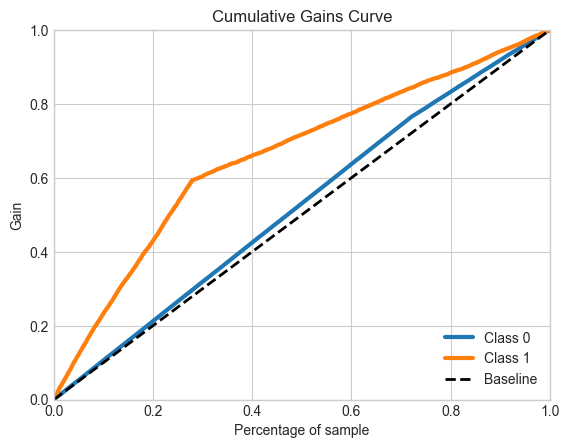

In [ ]:
import scipy
scipy.interp = np.interp

import scikitplot as skplt

# Curva de ganho acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

# 8.0 Model Performance

In [ ]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    # Fazendo a soma acumulada da response e dividindo por cada uma das linhas
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [ ]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    # Fazendo a soma acumulada da response e dividindo por cada uma das linhas
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [ ]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['propensity_score'] = yhat_knn[:,1].tolist()

# sorted clients by propensity score
df8 = df8.sort_values( 'propensity_score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute recall at k
recall_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( recall_at_50))

Precision at K: 0.35294117647058826
Recall at K: 0.0019208195496745277
